Original Shape: (9011, 6)
Monthly VAR Dataset Shape: (202, 4)
            Oil_Returns  USD_Returns  Interest_Rate_Diff  Inflation_Diff
Date                                                                    
2006-02-28    -0.045062     0.002784            0.154167        0.393741
2006-03-31     0.030340     0.002162            0.156413       -0.315244
2006-04-30     0.124024    -0.007316            0.265531       -0.078496
2006-05-31    -0.006899    -0.022152            0.118382        0.418018
2006-06-30    -0.017654     0.012038           -0.001462       -0.282535

--- Stationarity Check ---
Oil_Returns: p-value = 0.0000 (Stationary)
USD_Returns: p-value = 0.0000 (Stationary)
Interest_Rate_Diff: p-value = 0.0000 (Stationary)
Inflation_Diff: p-value = 0.0000 (Stationary)

--- Fitting VAR Model ---
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -18.79      -18.73   6.878e-0

/Users/admin/week11/brent-oil-bayesian-change-point-analysis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/admin/week11/brent-oil-bayesian-change-point-analysis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/admin/week11/brent-oil-bayesian-change-point-analysis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/admin/week11/brent-oil-bayesian-change-point-analysis/.venv/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/admin/week11/brent-oil-bayesian-change-point-analysis/.venv/lib/python3.10/site-packages/

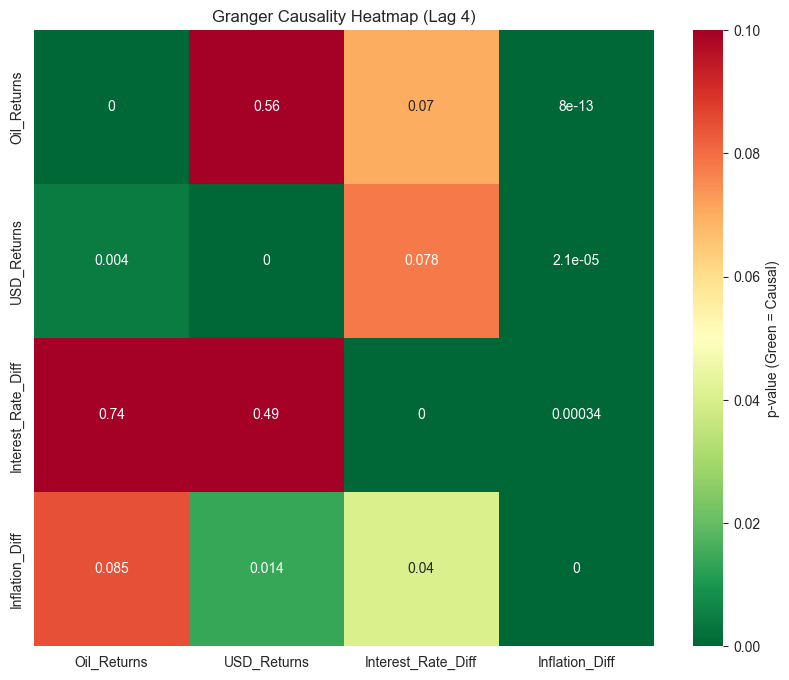


--- Impulse Response Analysis ---


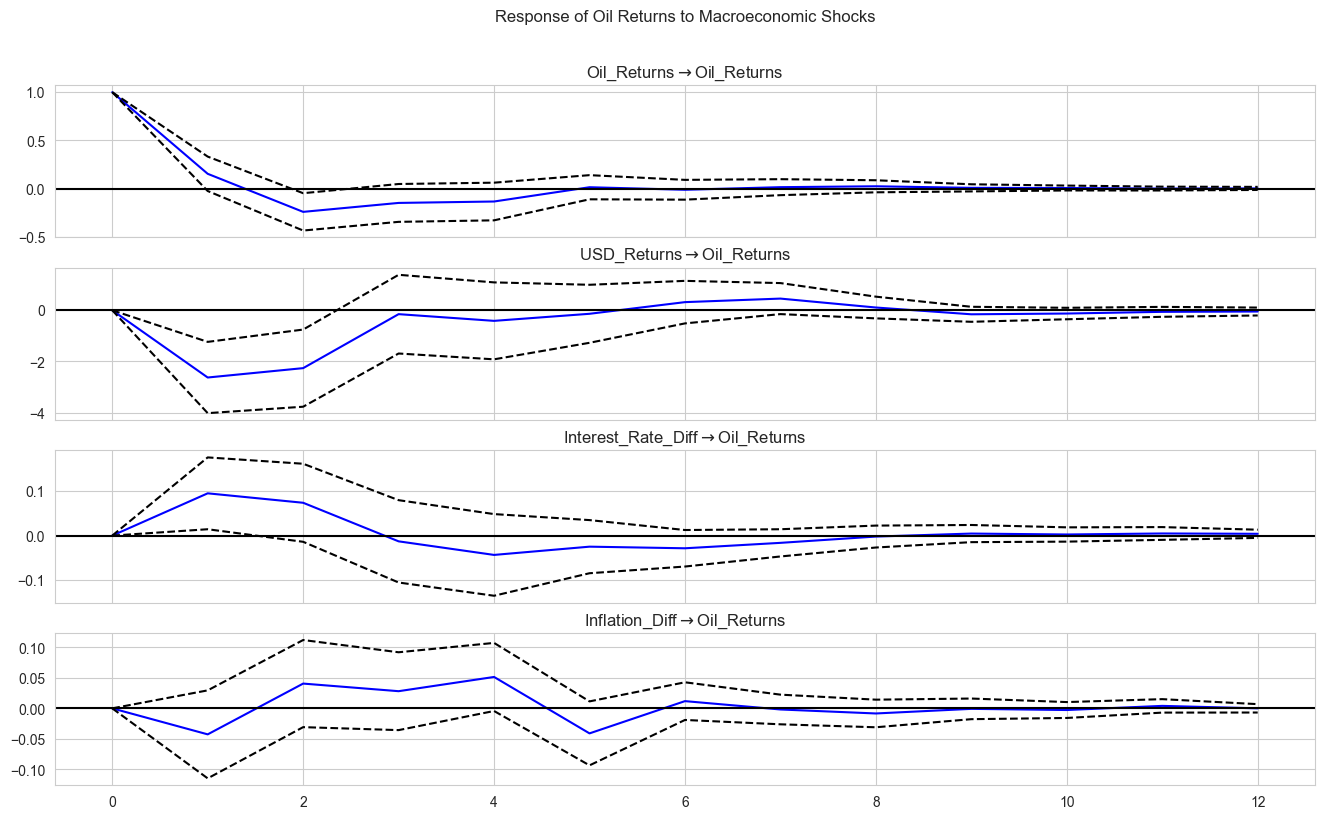

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

# Setup
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 8)

# 1. Load Your New Enriched Data
# Adjust path if necessary
DATA_PATH = '../data/processed/brent_oil_enriched.csv'
df = pd.read_csv(DATA_PATH, index_col='Date', parse_dates=True)

print("Original Shape:", df.shape)

# 2. Resample to Monthly Averages (The "Sweet Spot" for Macro Analysis)
# We aggregate by mean to smooth out daily noise and align with CPI/GDP
df_monthly = df.resample('ME').mean() # 'ME' is Month End

# 3. Data Transformations (Making it Stationary)
# VAR requires stationary data (no trends).
# - Oil Price -> Log Returns
# - GDP -> Log Difference (Growth Rate)
# - CPI -> Already used Inflation, but taking diff is safer
# - USD Index -> Log Returns

# Create a clean DataFrame for VAR
var_data = pd.DataFrame()

var_data['Oil_Returns'] = np.log(df_monthly['Price']).diff()
var_data['USD_Returns'] = np.log(df_monthly['USD_Index']).diff()
var_data['Interest_Rate_Diff'] = df_monthly['Interest_Rate'].diff() # First difference
var_data['Inflation_Diff'] = df_monthly['Inflation_Rate'].diff()    # Change in inflation

# Drop NaN created by differencing
var_data = var_data.dropna()

print("Monthly VAR Dataset Shape:", var_data.shape)
print(var_data.head())

# 4. Check Stationarity (ADF Test)
# If p-value > 0.05, the data is NOT ready.
def check_stationarity(data):
    for col in data.columns:
        result = adfuller(data[col])
        print(f"{col}: p-value = {result[1]:.4f} ({'Stationary' if result[1] < 0.05 else 'Non-Stationary'})")

print("\n--- Stationarity Check ---")
check_stationarity(var_data)

# 5. Fit the Vector Autoregression (VAR) Model
print("\n--- Fitting VAR Model ---")
model = VAR(var_data)

# Select best lag order automatically based on AIC (Akaike Information Criterion)
lag_order_results = model.select_order(maxlags=15)
print(lag_order_results.summary())

# Fit using the best lag (or hardcode a reasonable one like 3 months)
optimal_lag = lag_order_results.aic
print(f"\nTraining VAR with Lag Order: {optimal_lag}")
var_result = model.fit(optimal_lag)

print(var_result.summary())

# 6. Granger Causality Matrix
# Question: Does "Column X" cause "Column Y"?
print("\n--- Granger Causality Analysis (p-values) ---")
print("Null Hypothesis: Row DOES NOT cause Column (Low p-value = CAUSALITY)")

variables = var_data.columns
causality_matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

for col in variables:
    for row in variables:
        if col != row:
            test_result = grangercausalitytests(var_data[[col, row]], maxlag=optimal_lag, verbose=False)
            # Extract p-value for the optimal lag (using F-test)
            p_value = test_result[optimal_lag][0]['ssr_ftest'][1]
            causality_matrix.loc[row, col] = p_value

# Plot Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(causality_matrix, annot=True, cmap='RdYlGn_r', vmin=0, vmax=0.1, cbar_kws={'label': 'p-value (Green = Causal)'})
plt.title(f'Granger Causality Heatmap (Lag {optimal_lag})')
plt.show()

# 7. Impulse Response Function (IRF)
# Question: If we shock Interest Rates, what happens to Oil?
print("\n--- Impulse Response Analysis ---")
irf = var_result.irf(12) # 12 months horizon

# Plot the response of 'Oil_Returns' to shocks in other variables
irf.plot(response='Oil_Returns', figsize=(14, 8))
plt.suptitle('Response of Oil Returns to Macroeconomic Shocks', y=1.02)
plt.show()


--- Forecast Error Variance Decomposition (FEVD) ---
FEVD for Oil_Returns
      Oil_Returns  USD_Returns  Interest_Rate_Diff  Inflation_Diff
0        1.000000     0.000000            0.000000        0.000000
1        0.927052     0.045423            0.021317        0.006207
2        0.876296     0.078192            0.034346        0.011167
3        0.875156     0.077334            0.034026        0.013484
4        0.862928     0.079002            0.036734        0.021337
5        0.856635     0.078764            0.038269        0.026332
6        0.854718     0.078767            0.039851        0.026664
7        0.853139     0.079872            0.040375        0.026614
8        0.852875     0.079933            0.040376        0.026816
9        0.852735     0.080056            0.040403        0.026806
10       0.852628     0.080146            0.040404        0.026822
11       0.852527     0.080149            0.040456        0.026867
12       0.852493     0.080152            0.040490    

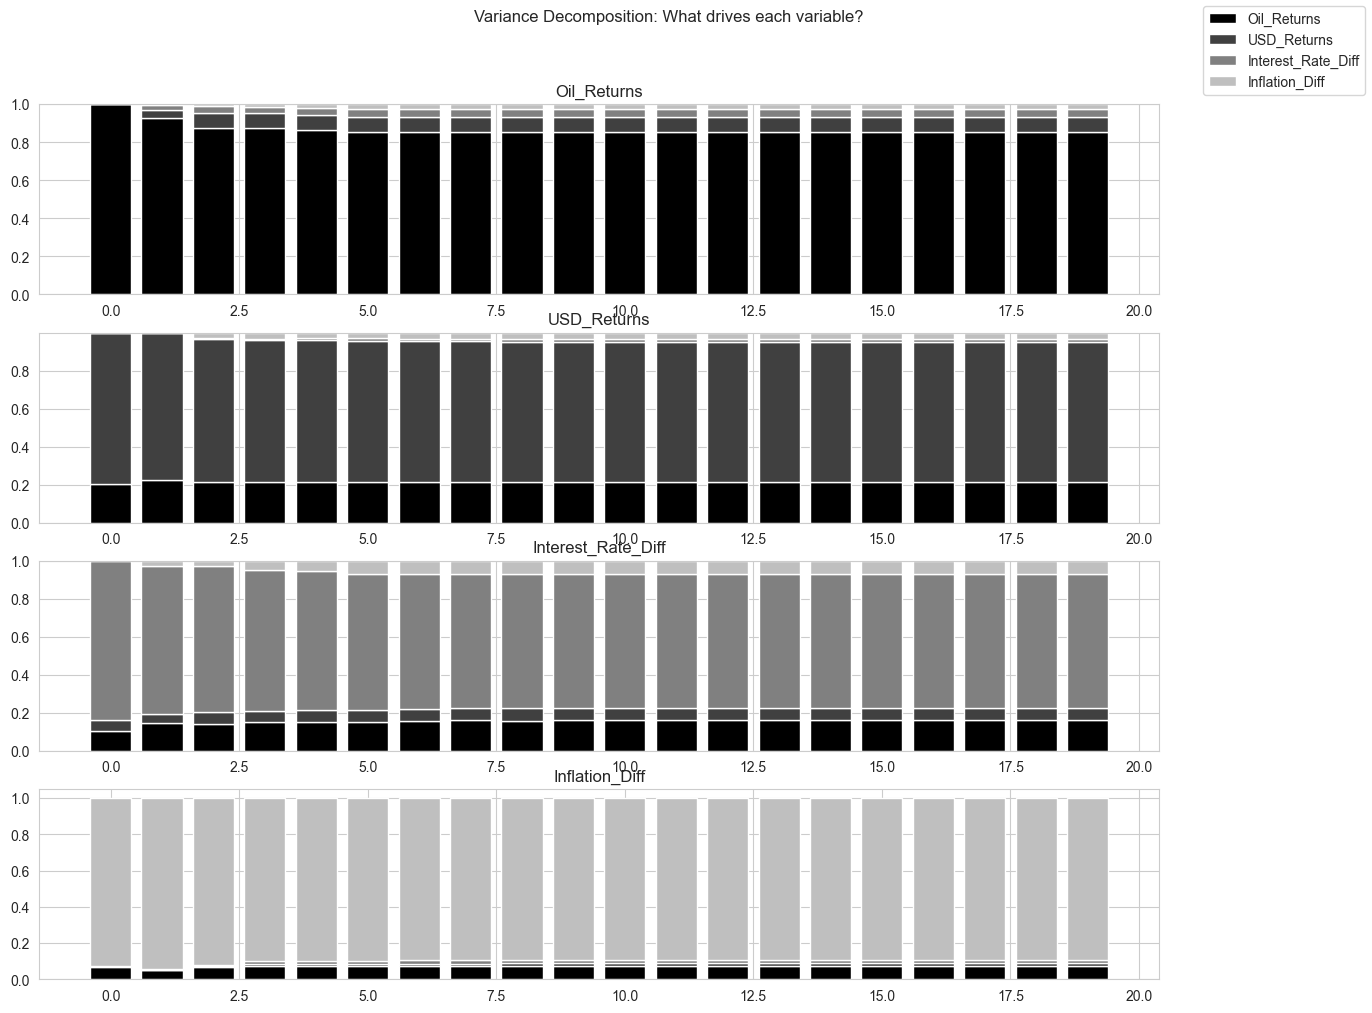

In [2]:
# --- ADVANCED EXTENSION 1: Variance Decomposition (FEVD) ---

# Compute FEVD for 20 steps (months) ahead
fevd = var_result.fevd(20)

print("\n--- Forecast Error Variance Decomposition (FEVD) ---")
print(fevd.summary())

# Plot the Decomposition for 'Oil_Returns' ONLY (to keep it clean)
# This shows what drives Oil Prices over time
fevd.plot(figsize=(14, 10))
plt.suptitle("Variance Decomposition: What drives each variable?", y=1.02)
plt.show()

# Interpretation Tip:
# Look at the 'Oil_Returns' plot.
# - The Blue area is "Oil explaining itself" (Momentum/Supply shocks).
# - The Orange/Green areas are "Macro Factors" (USD, Rates).
# - If the USD area grows over time (x-axis), it means the Dollar's impact is "sticky" or long-term.

<Figure size 1400x600 with 0 Axes>

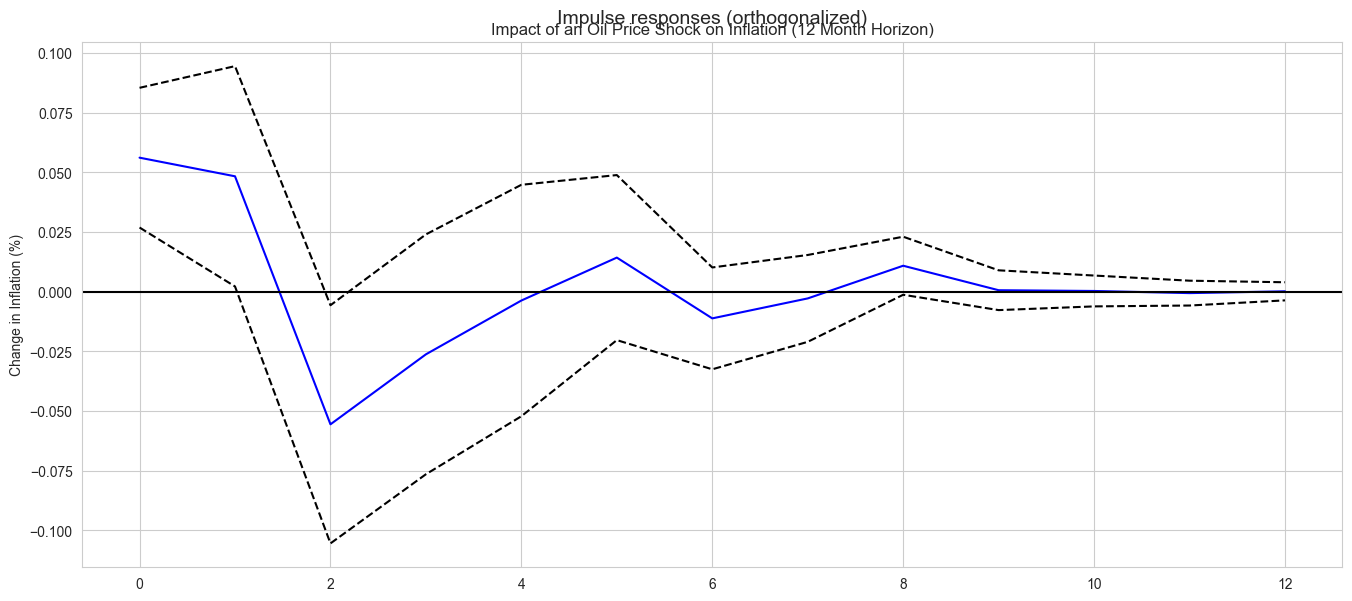

<Figure size 1400x600 with 0 Axes>

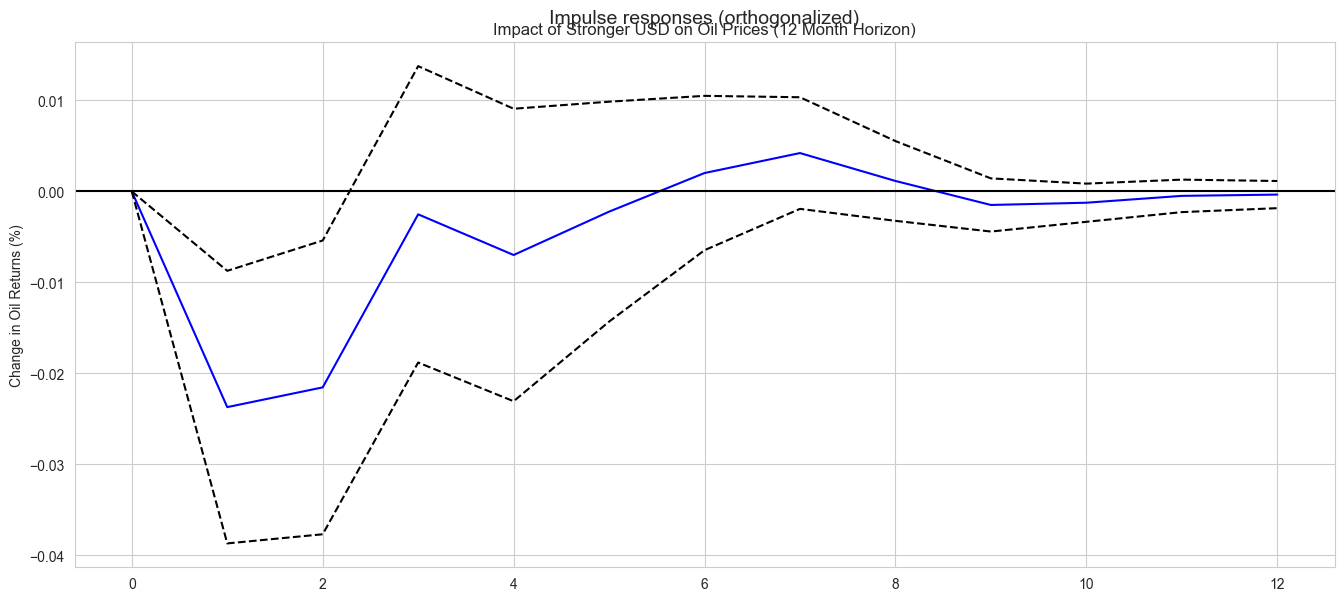

<Figure size 1400x600 with 0 Axes>

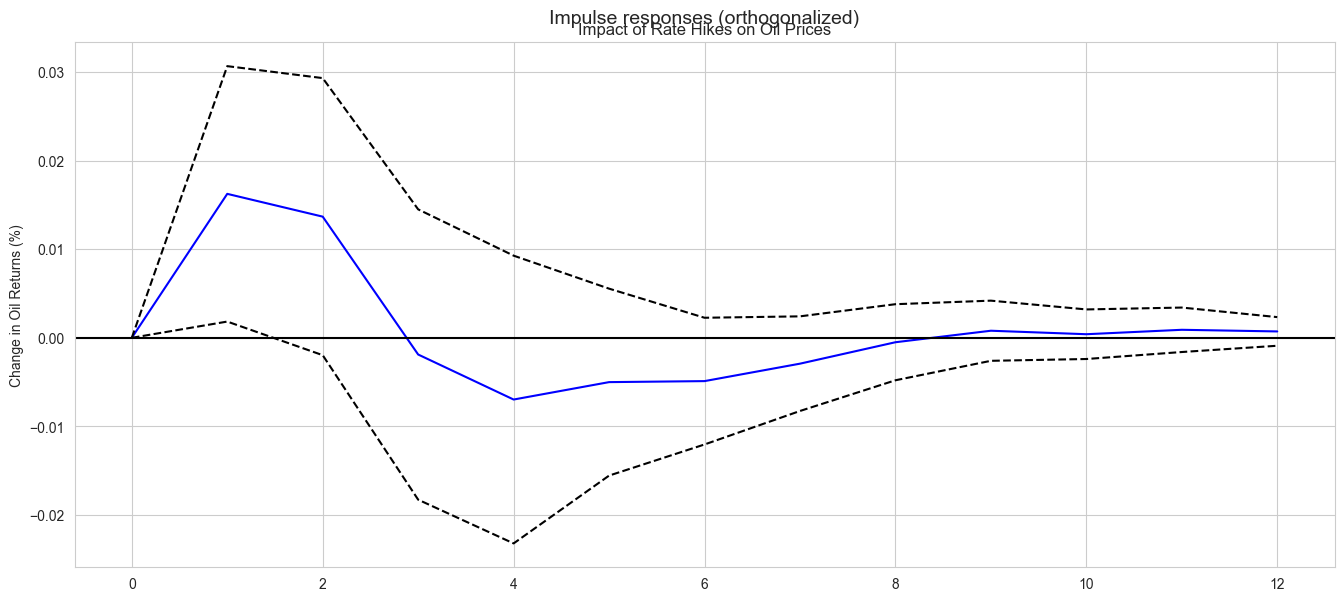

In [3]:
# --- ADVANCED EXTENSION 2: Targeted Impulse Response ---

# 1. Oil Shock -> Inflation Response
# Question: "If Oil jumps 1%, what happens to Inflation?"
irf = var_result.irf(12)

plt.figure(figsize=(14, 6))
irf.plot(impulse='Oil_Returns', response='Inflation_Diff', orth=True, figsize=(14, 6))
plt.title("Impact of an Oil Price Shock on Inflation (12 Month Horizon)")
plt.ylabel("Change in Inflation (%)")
plt.grid(True)
plt.show()

# 2. USD Shock -> Oil Price Response
# Question: "If the Dollar gets stronger, does Oil crash?"
plt.figure(figsize=(14, 6))
irf.plot(impulse='USD_Returns', response='Oil_Returns', orth=True, figsize=(14, 6))
plt.title("Impact of Stronger USD on Oil Prices (12 Month Horizon)")
plt.ylabel("Change in Oil Returns (%)")
plt.grid(True)
plt.show()

# 3. Interest Rate Shock -> Oil Price Response
# Question: "Does the Fed hiking rates actually lower oil prices?"
plt.figure(figsize=(14, 6))
irf.plot(impulse='Interest_Rate_Diff', response='Oil_Returns', orth=True, figsize=(14, 6))
plt.title("Impact of Rate Hikes on Oil Prices")
plt.ylabel("Change in Oil Returns (%)")
plt.grid(True)
plt.show()